# PID Tuner

In [205]:
from IPython.display import display
from sympy import *
init_printing(use_latex='mathjax')

# Symbols
Kp, Ki = symbols('K_p K_i')
p, R, L = symbols('p R L')

PI = Kp * (p + Ki) / p
dc_motor = 1/(R+p*L)
G_open = PI * dc_motor
G_closed = G_open / (1 + G_open)

display(G_closed)
display(simplify(G_closed))
print(type(G_closed))

num, den = fraction(G_closed)

display('Numerator', num)
display('Denominator', simplify(den))

display(Poly(num, p).coeffs())
display(Poly(simplify(den), p).coeffs())

print(latex(Poly(num,p)))
print(latex(Poly(simplify(den),p)))

         Kₚ⋅(Kᵢ + p)         
─────────────────────────────
            ⎛Kₚ⋅(Kᵢ + p)    ⎞
p⋅(L⋅p + R)⋅⎜─────────── + 1⎟
            ⎝p⋅(L⋅p + R)    ⎠

       Kₚ⋅(Kᵢ + p)       
─────────────────────────
Kₚ⋅(Kᵢ + p) + p⋅(L⋅p + R)

<class 'sympy.core.mul.Mul'>


'Numerator'

Kₚ⋅(Kᵢ + p)

'Denominator'

Kₚ⋅(Kᵢ + p) + p⋅(L⋅p + R)

[Kₚ, Kᵢ⋅Kₚ]

[L, Kₚ + R, Kᵢ⋅Kₚ]

\operatorname{Poly}{\left( K_{p} p + K_{i} K_{p}, p, domain=\mathbb{Z}\left[K_{i}, K_{p}\right] \right)}
\operatorname{Poly}{\left( L p^{2} + \left(K_{p} + R\right) p + K_{i} K_{p}, p, domain=\mathbb{Z}\left[K_{i}, K_{p}, L, R\right] \right)}


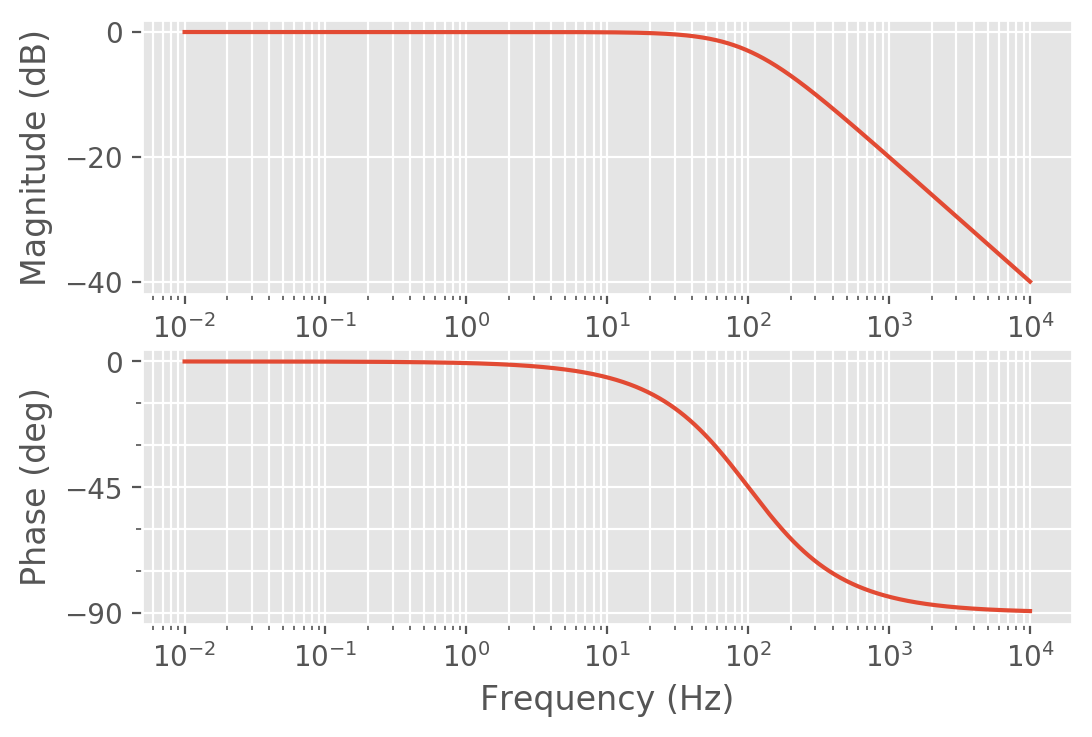

In [206]:
%matplotlib inline
from pylab import *
mpl.rcParams['figure.dpi']= 200
plt.style.use('ggplot')

from control import *

mag, phase, omega = bode_plot(tf([1],[0.01/(2*pi), 1]), 2*np.pi*np.logspace(-2,4,1000), dB=1, Hz=1, deg=1)


Kp = 502.65482457436696 | Ki = 0.25



     1
-----------
0.4 s + 0.1


502.7 s + 125.7
---------------
       s


502.7 s + 125.7
---------------
0.4 s^2 + 0.1 s


     502.7 s + 125.7
-------------------------
0.4 s^2 + 502.8 s + 125.7

1 states have been removed from the model



  1257
--------
s + 1257

Kp/L = 1256.6370614359173
Kp/L/(2pi) = 200.0
0.9189974078420567 A
2.0 ms
dc gain: 0.9999999999999998
zero: []
pole: [-1256.63706144]


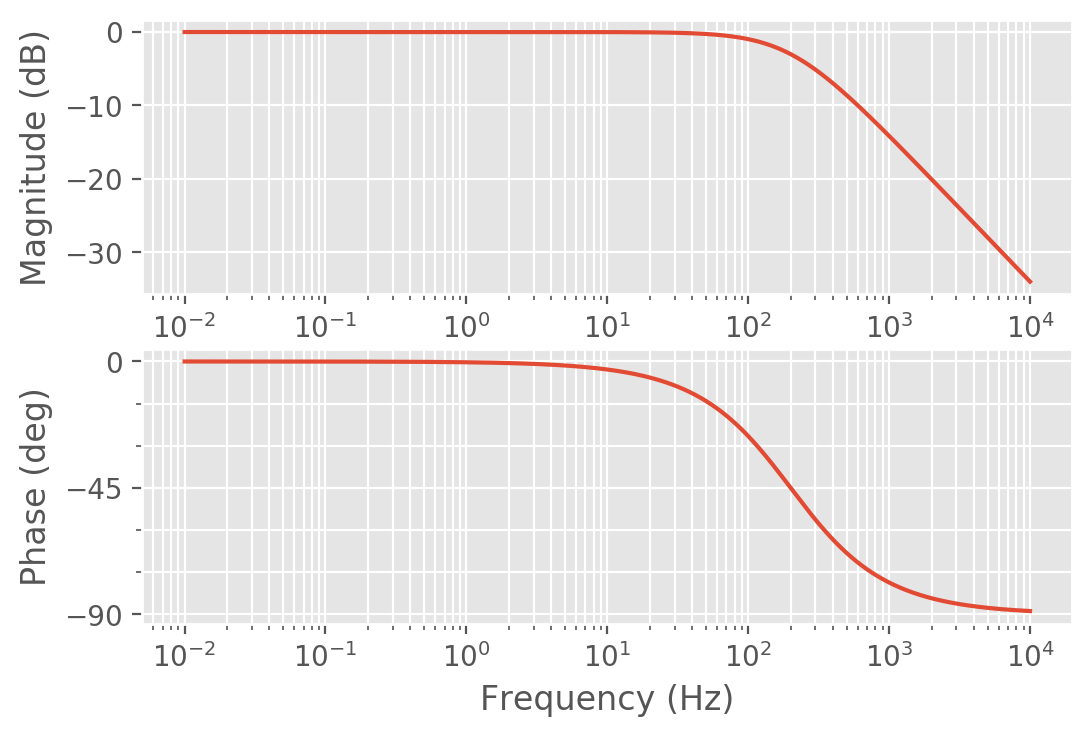

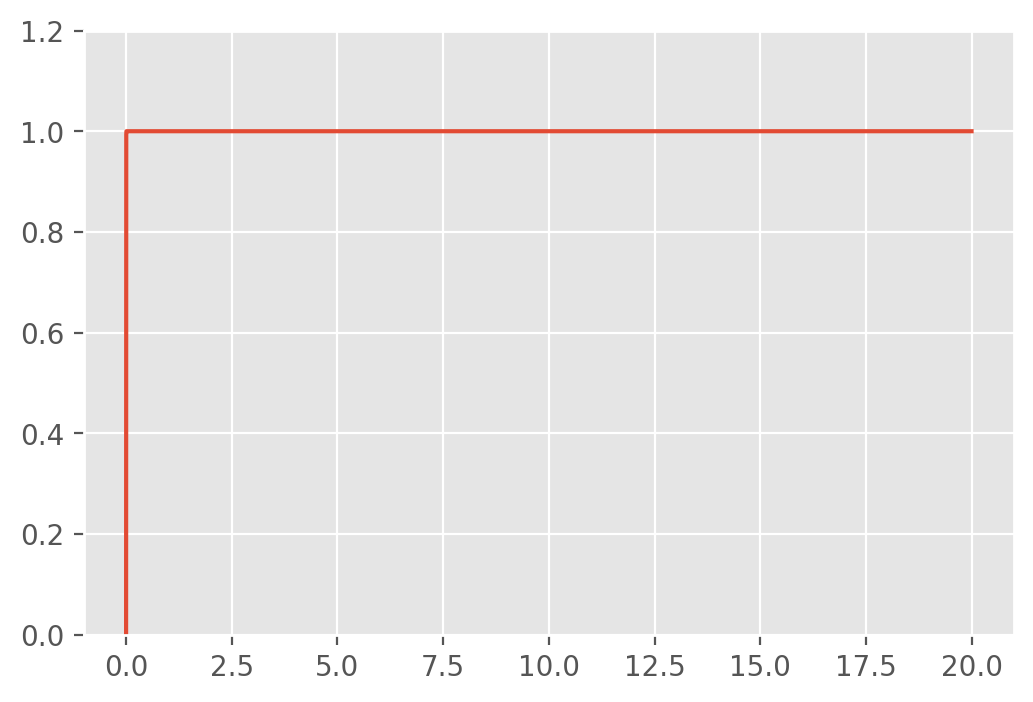

In [207]:
from pylab import np, plt

def get_coeffs_dc_motor_current_regulator(R, L, Bandwidth_Hz):
    Kp = Bandwidth_Hz * 2 * np.pi * L
    Ki = R / L
    return Kp, Ki

import control
from control import bode_plot

# R = 3 # Ohm
R = 0.1 # Ohm
L = 0.4 # H

Kp, Ki = get_coeffs_dc_motor_current_regulator(R, L, 200)
# Kp = 0.1; Ki = 1; # force the closed loop tf to have a pair of complex pole and observe its step response
print('Kp =', Kp, '|', 'Ki =', Ki)

dc_motor = control.tf([1], [L, R])
pi_regulator = control.tf([Kp, Kp*Ki], [1, 0])
display(dc_motor)
display(pi_regulator)
# figure()
# mag, phase, omega = bode_plot(dc_motor, 2*np.pi*np.logspace(-2,4,1000), dB=1, Hz=1, deg=1)
# figure()
# mag, phase, omega = bode_plot(pi_regulator, 2*np.pi*np.logspace(-2,4,1000), dB=1, Hz=1, deg=1)

open_sys = control.series(pi_regulator, dc_motor)
closed_sys = control.feedback(open_sys, 1, sign=-1)

# open_sys = pi_regulator * dc_motor
# closed_sys = open_sys / (1+open_sys)

display(open_sys)
display(closed_sys)
closed_sys = control.minreal(closed_sys)
display(closed_sys)
print('Kp/L =', Kp/L)
print('Kp/L/(2pi) =', Kp/L/(2*np.pi))

# figure()
# mag, phase, omega = bode_plot(open_sys, 2*np.pi*np.logspace(-2,4,1000), dB=1, Hz=1, deg=1)
plt.figure()
mag, phase, omega = bode_plot(closed_sys, 2*np.pi*np.logspace(-2,4,1000), dB=1, Hz=1, deg=1)

# T, yout = control.step_response(closed_sys, np.arange(0,0.02,1e-5))
T, yout = control.step_response(closed_sys, np.arange(0,20,1e-3))
plt.figure()
plt.plot(T, yout)
plt.ylim([0,1.2])

# 上升时间：
print(
    min(yout, key=lambda x:abs(x-0.9)), 'A'
) 
print(
    T[(np.abs(yout-0.9)).argmin()] * 1000, 'ms' 
)

print('dc gain:', control.dcgain(closed_sys))
print('zero:', control.zero(closed_sys))
print('pole:', control.pole(closed_sys))

# For Fun: Varying Parameters

In [208]:
R = 0.1 # Ohm
L = 0.4 # H

list_zeros = []
list_poles = []
for L in np.arange(0.1, 3.2, 0.3):
    Kp, Ki = get_coeffs_dc_motor_current_regulator(R, L, 200)
    print(f'Kp = {Kp:g} | Ki = {Ki:g}')
    dc_motor = control.tf([1], [L, R])
    pi_regulator = control.tf([Kp, Kp*Ki], [1, 0])
    open_sys = control.series(pi_regulator, dc_motor)
    closed_sys = control.feedback(open_sys, 1, sign=-1)

    closed_sys = control.minreal(closed_sys)
    
    list_zeros.append( control.zero(closed_sys) )
    list_poles.append( control.pole(closed_sys) )

for poles, zeros in zip(list_poles, list_zeros):
    print(poles, zeros)



Kp = 125.664 | Ki = 1
1 states have been removed from the model
Kp = 502.655 | Ki = 0.25
1 states have been removed from the model
Kp = 879.646 | Ki = 0.142857
1 states have been removed from the model
Kp = 1256.64 | Ki = 0.1
1 states have been removed from the model
Kp = 1633.63 | Ki = 0.0769231
1 states have been removed from the model
Kp = 2010.62 | Ki = 0.0625
1 states have been removed from the model
Kp = 2387.61 | Ki = 0.0526316
1 states have been removed from the model
Kp = 2764.6 | Ki = 0.0454545
1 states have been removed from the model
Kp = 3141.59 | Ki = 0.04
1 states have been removed from the model
Kp = 3518.58 | Ki = 0.0357143
1 states have been removed from the model
Kp = 3895.57 | Ki = 0.0322581
1 states have been removed from the model
[-1256.63706144] []
[-1256.63706144] []
[-1256.63706144] []
[-1256.63706144] []
[-1256.63706144] []
[-1256.63706144] []
[-1256.63706144] []
[-1256.63706144] []
[-1256.63706144] []
[-1256.63706144] []
[-1256.63706144] []


# For Fun: Pole Loci Varying Kp

Kp = 1 | Ki = 10
0 states have been removed from the model
Kp = 2 | Ki = 10
0 states have been removed from the model
Kp = 3 | Ki = 10
0 states have been removed from the model
Kp = 4 | Ki = 10
0 states have been removed from the model
Kp = 5 | Ki = 10
0 states have been removed from the model
Kp = 6 | Ki = 10
0 states have been removed from the model
Kp = 7 | Ki = 10
0 states have been removed from the model
Kp = 8 | Ki = 10
0 states have been removed from the model
Kp = 9 | Ki = 10
0 states have been removed from the model
Kp = 10 | Ki = 10
0 states have been removed from the model
Kp = 11 | Ki = 10
0 states have been removed from the model
Kp = 12 | Ki = 10
0 states have been removed from the model
Kp = 13 | Ki = 10
0 states have been removed from the model
Kp = 14 | Ki = 10
0 states have been removed from the model
Kp = 15 | Ki = 10
0 states have been removed from the model
Kp = 16 | Ki = 10
0 states have been removed from the model
Kp = 17 | Ki = 10
0 states have been removed from

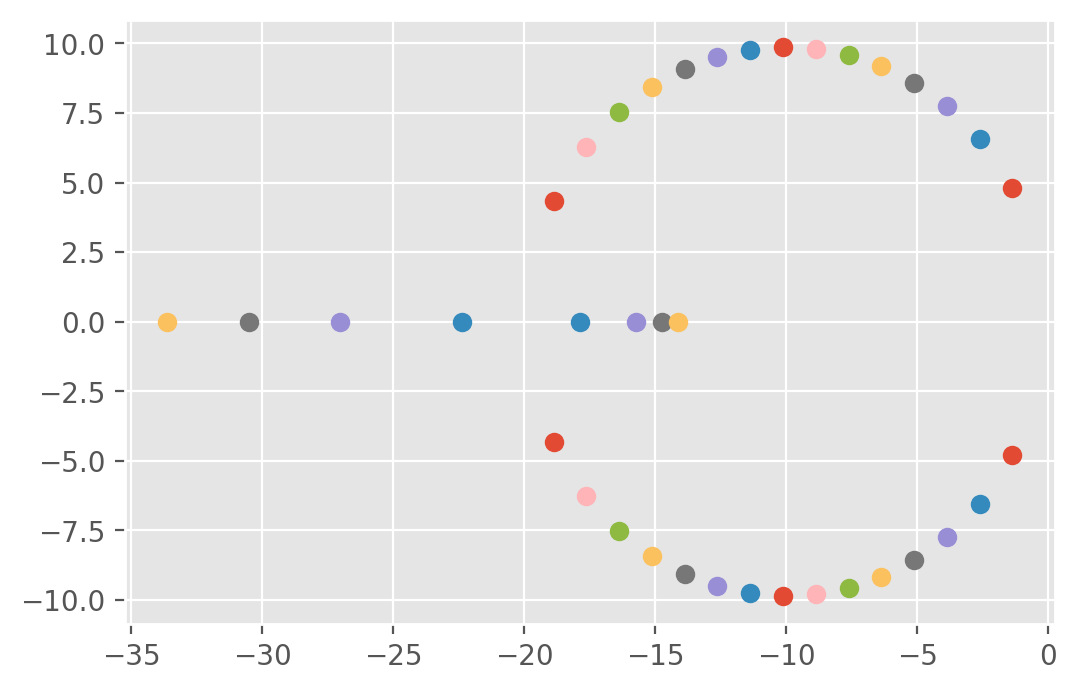

In [209]:
R = 0.1 # Ohm
L = 0.4 # H

list_zeros = []
list_poles = []
Kp, Ki = get_coeffs_dc_motor_current_regulator(R, L, 200)
Kp, Ki = 10, 10

for Kp in np.arange(1, 20, 1):
    print(f'Kp = {Kp:g} | Ki = {Ki:g}')
    dc_motor = control.tf([1], [L, R])
    pi_regulator = control.tf([Kp, Kp*Ki], [1, 0])
    open_sys = control.series(pi_regulator, dc_motor)
    closed_sys = control.feedback(open_sys, 1, sign=-1)

    closed_sys = control.minreal(closed_sys)

    list_zeros.append( control.zero(closed_sys) )
    list_poles.append( control.pole(closed_sys) )

for poles, zeros in zip(list_poles, list_zeros):
    print('poles:', poles, '| zeros:', zeros)
    plt.plot(poles.real, poles.imag, 'o')


# Speed PI Regulator

In [210]:
from IPython.display import display
from sympy import *
init_printing(use_latex='mathjax')

# From current loop
p, L, Kp = symbols('p L K^i_p')
Gi_closed = 1 / (1+L/Kp*p)

# Symbols
speedKp, speedKi = symbols('K^\omega_p K^\omega_i')
J_s, n_pp = symbols('J_s n_{pp}')

speedPI = speedKp * (p + speedKi) / p
dc_motor_motion = n_pp/ J_s /p
G_open = dc_motor_motion * Gi_closed * speedPI

display('Open tf:', G_open)
print(latex(G_open))
# display(simplify(G_open))

G_closed = G_open / (1 + G_open)

display('Closed tf:', G_closed)
# print(latex(G_closed))
display(simplify(G_closed))
print(latex(simplify(G_closed)))
# print(type(G_closed))

num, den = fraction(G_closed)
display('Numerator', num)
display('Denominator', simplify(den))

# display(Poly(num, p).coeffs())
# display(Poly(simplify(den), p).coeffs())

# print(latex(Poly(num,p)))
# print(latex(Poly(simplify(den),p)))


'Open tf:'

K_p__\omega⋅n_{pp}⋅(K_i__\omega + p)
────────────────────────────────────
              2 ⎛    L⋅p⎞           
          Jₛ⋅p ⋅⎜1 + ───⎟           
                ⎝    Kⁱₚ⎠           

\frac{K^\omega_p n_{pp} \left(K^\omega_i + p\right)}{J_{s} p^{2} \left(1 + \frac{L p}{K^{i}_{p}}\right)}


'Closed tf:'

           K_p__\omega⋅n_{pp}⋅(K_i__\omega + p)           
──────────────────────────────────────────────────────────
    2 ⎛    L⋅p⎞ ⎛    K_p__\omega⋅n_{pp}⋅(K_i__\omega + p)⎞
Jₛ⋅p ⋅⎜1 + ───⎟⋅⎜1 + ────────────────────────────────────⎟
      ⎝    Kⁱₚ⎠ ⎜                  2 ⎛    L⋅p⎞           ⎟
                ⎜              Jₛ⋅p ⋅⎜1 + ───⎟           ⎟
                ⎝                    ⎝    Kⁱₚ⎠           ⎠

          K_p__\omega⋅Kⁱₚ⋅n_{pp}⋅(K_i__\omega + p)          
────────────────────────────────────────────────────────────
    2                                                       
Jₛ⋅p ⋅(Kⁱₚ + L⋅p) + K_p__\omega⋅Kⁱₚ⋅n_{pp}⋅(K_i__\omega + p)

\frac{K^\omega_p K^{i}_{p} n_{pp} \left(K^\omega_i + p\right)}{J_{s} p^{2} \left(K^{i}_{p} + L p\right) + K^\omega_p K^{i}_{p} n_{pp} \left(K^\omega_i + p\right)}


'Numerator'

K_p__\omega⋅n_{pp}⋅(K_i__\omega + p)

'Denominator'

    2                                                       
Jₛ⋅p ⋅(Kⁱₚ + L⋅p) + K_p__\omega⋅Kⁱₚ⋅n_{pp}⋅(K_i__\omega + p)
────────────────────────────────────────────────────────────
                            Kⁱₚ                             

BW_i: 200.0 Hz


'motion:'


33.33
-----
  s

speedKp = 25.1327 | speedKi = 558.505 | wzero = 88.8888888888889 Hz | cutoff = 133.33333333333334 Hz | ipole = 200.0 Hz
	 0.9002207991933703 A
	 9.040000000000001 ms
speedKp = 18.8496 | speedKi = 314.159 | wzero = 50.0 Hz | cutoff = 100.0 Hz | ipole = 200.0 Hz
	 0.8990956850146465 A
	 2.2300000000000004 ms
speedKp = 9.42478 | speedKi = 78.5398 | wzero = 12.5 Hz | cutoff = 50.0 Hz | ipole = 200.0 Hz
	 0.8993810741224034 A
	 4.66 ms
speedKp = 6.28319 | speedKi = 34.9066 | wzero = 5.555555555555556 Hz | cutoff = 33.333333333333336 Hz | ipole = 200.0 Hz
	 0.8999882991395796 A
	 7.6000000000000005 ms
speedKp = 4.71239 | speedKi = 19.635 | wzero = 3.125 Hz | cutoff = 25.0 Hz | ipole = 200.0 Hz
	 0.8998533777668205 A
	 10.81 ms
speedKp = 3.76991 | speedKi = 12.5664 | wzero = 2.0 Hz | cutoff = 20.0 Hz | ipole = 200.0 Hz
	 0.8999855089712125 A
	 14.16 ms
speedKp = 1.88496 | speedKi = 3.14159 | wzero = 0.5 Hz | cutoff = 10.0 Hz | ipole = 200.0 Hz
	 0.8999756149203111 A
	 31.650000000000006 ms


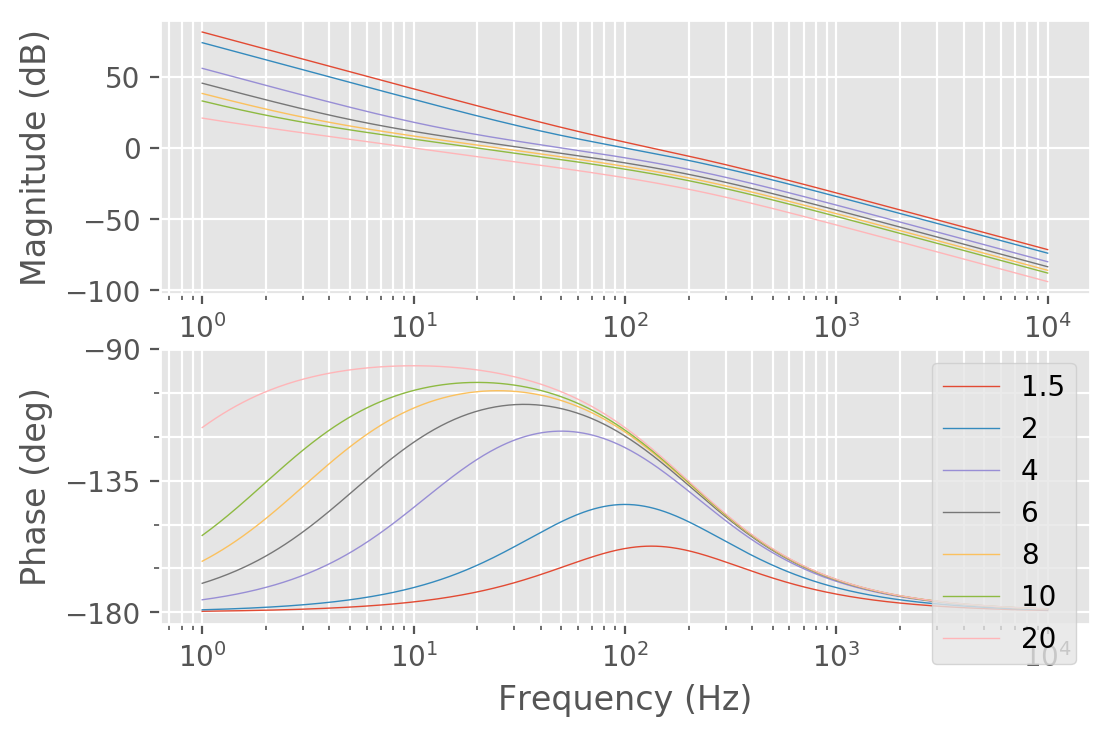

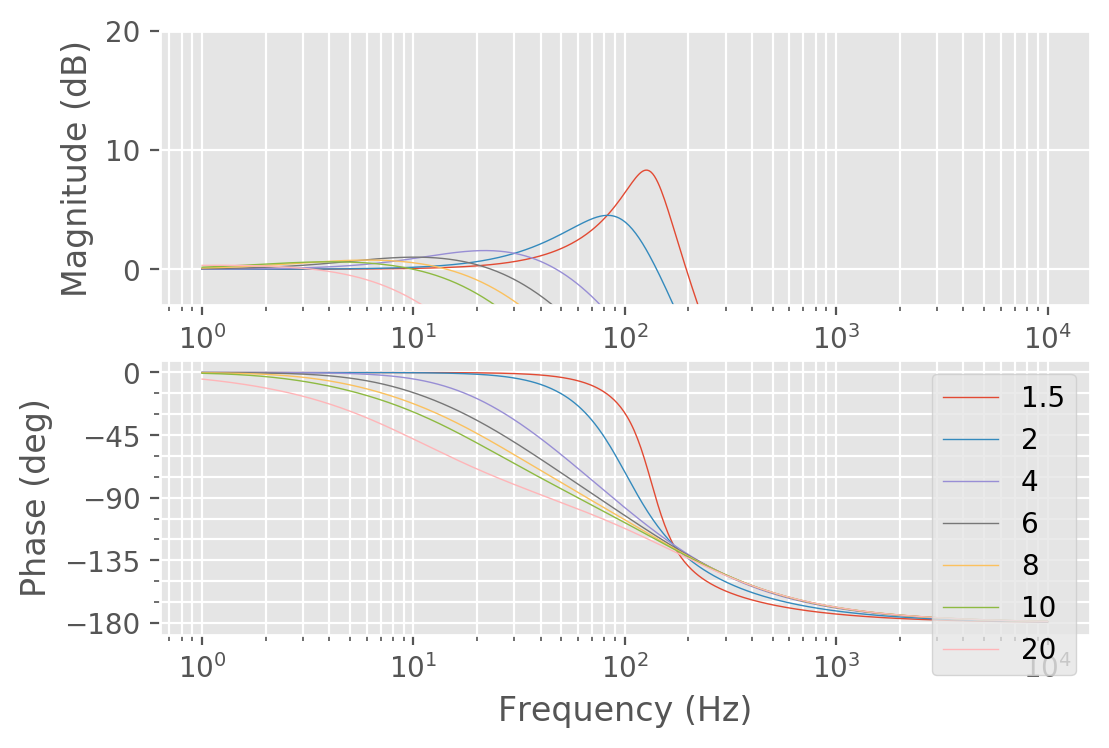

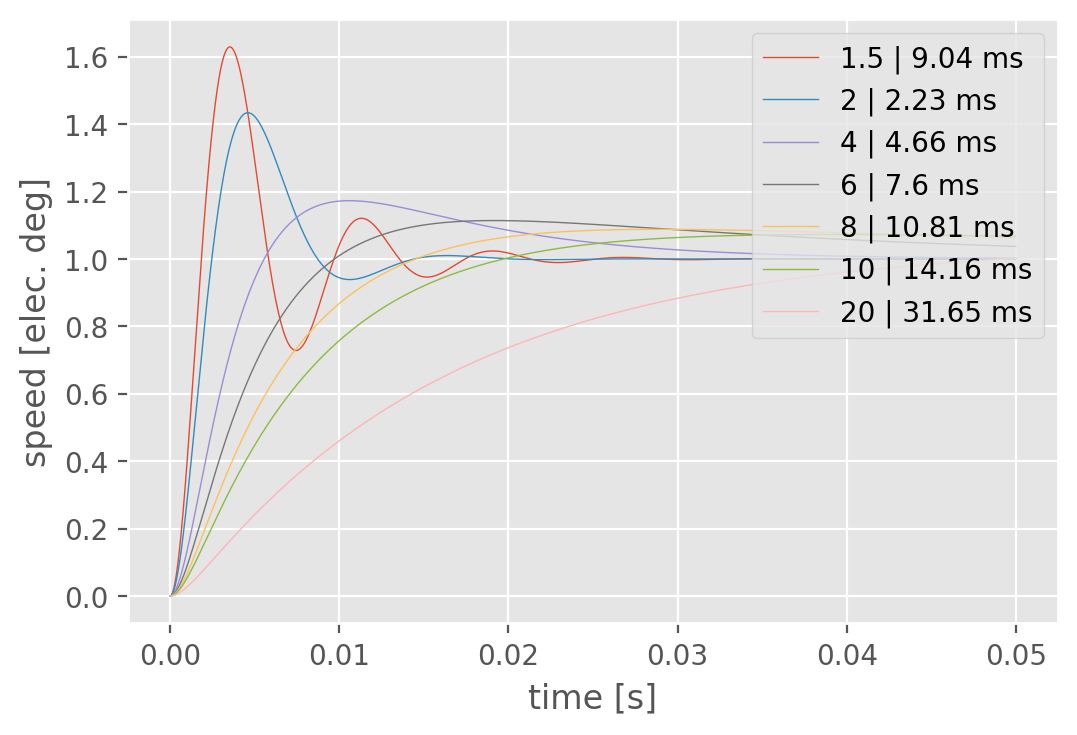

In [211]:
R = 0.1 # Ohm
L = 0.4 # H
Kp, Ki = get_coeffs_dc_motor_current_regulator(R, L, 200)
Gi_closed = control.tf([1], [L/Kp, 1])
currentBandwidth_radPerSec = Kp/L
print('BW_i:', currentBandwidth_radPersec/(2*np.pi), 'Hz')

def get_coeffs_dc_motor_SPEED_regulator(J_s, n_pp, delta, currentBandwidth_radPerSec):
    speedKi = currentBandwidth_radPerSec / delta**2
    speedKp = J_s/n_pp * delta * speedKi
    return speedKp, speedKi

n_pp = 2
J_s  = 0.06
dc_motor_motion = control.tf([n_pp/J_s], [1, 0])
display('motion:', dc_motor_motion)

delta = 4 # damping factor (nothing similar to damping ratio for 2nd-order tf)

fig1, fig2, fig3 = figure(1), figure(2), figure(3)

# if True:
for delta in [1.5, 2, 4, 6, 8, 10, 20]:

    speedKp, speedKi = get_coeffs_dc_motor_SPEED_regulator(J_s, n_pp, delta, currentBandwidth_radPerSec)
#     speedKp *= 1000
    print(f'speedKp = {speedKp:g}', f'speedKi = {speedKi:g}', f'wzero = {speedKi/2/np.pi} Hz', f'cutoff = {delta*speedKi/2/np.pi} Hz', f'ipole = {Kp/L/2/np.pi} Hz', sep=' | ')

    speedPI = control.tf([speedKp, speedKp*speedKi], [1, 0])
#     display('speedPI:', speedPI)

    Gw_open = dc_motor_motion * Gi_closed * speedPI
#     display('speed open loop:', Gw_open)
#     print(control.dcgain(Gw_open), 
#           control.zero(Gw_open)/2/np.pi,
#           control.pole(Gw_open)/2/np.pi, sep='\n')

    plt.figure(1)
    mag, phase, omega = bode_plot(Gw_open, 2*np.pi*np.logspace(0,4,500), dB=1, Hz=1, deg=1, lw='0.5', label=f'{delta:g}')
#     gm,pm,sm,wg,wp,ws = control.stability_margins(Gw_open)
#     print(f'GM={gm}, PM={pm:g} deg',wg,'Hz',wp,'Hz')

    Gw_closed = Gw_open / (1+Gw_open)

    plt.figure(2)
    mag, phase, omega = bode_plot(Gw_closed, 2*np.pi*np.logspace(0,4,500), dB=1, Hz=1, deg=1, lw='0.5', label=f'{delta:g}')

    plt.figure(3)
    T, yout = control.step_response(Gw_closed, np.arange(0,0.05,1e-5))
    # 上升时间：
    print('\t', 
        min(yout, key=lambda x:abs(x-0.9)), 'A'
    )
    rise_time_ms = T[(np.abs(yout-0.9)).argmin()] * 1000
    print('\t', 
        rise_time_ms, 'ms' 
    )
    plt.plot(T, yout, lw='0.5', label=f'{delta:g} | {rise_time_ms:g} ms')


fig2.axes[0].set_ylim([-3, 20]) # -3dB
fig3.axes[0].set_xlabel('time [s]')
fig3.axes[0].set_ylabel('speed [elec. deg]')

for i in [1,2,3]:
    plt.figure(i)
    plt.legend(loc='upper right')


BW_current_Hz = 110
speedKp = 5.18363 | speedKi = 43.1969 | wzero = 6.875 Hz | cutoff = 27.5 Hz | ipole = 110.0 Hz
BW_current_Hz = 120
speedKp = 5.65487 | speedKi = 47.1239 | wzero = 7.499999999999999 Hz | cutoff = 29.999999999999996 Hz | ipole = 119.99999999999999 Hz
BW_current_Hz = 130
speedKp = 6.12611 | speedKi = 51.0509 | wzero = 8.125 Hz | cutoff = 32.5 Hz | ipole = 130.0 Hz
BW_current_Hz = 140
speedKp = 6.59734 | speedKi = 54.9779 | wzero = 8.75 Hz | cutoff = 35.0 Hz | ipole = 140.0 Hz
BW_current_Hz = 150
speedKp = 7.06858 | speedKi = 58.9049 | wzero = 9.375 Hz | cutoff = 37.5 Hz | ipole = 150.0 Hz
BW_current_Hz = 160
speedKp = 7.53982 | speedKi = 62.8319 | wzero = 10.0 Hz | cutoff = 40.0 Hz | ipole = 160.0 Hz
BW_current_Hz = 170
speedKp = 8.01106 | speedKi = 66.7588 | wzero = 10.625 Hz | cutoff = 42.5 Hz | ipole = 170.0 Hz
BW_current_Hz = 180
speedKp = 8.4823 | speedKi = 70.6858 | wzero = 11.25 Hz | cutoff = 45.0 Hz | ipole = 180.0 Hz
BW_current_Hz = 190
speedKp = 8.95354 | spe

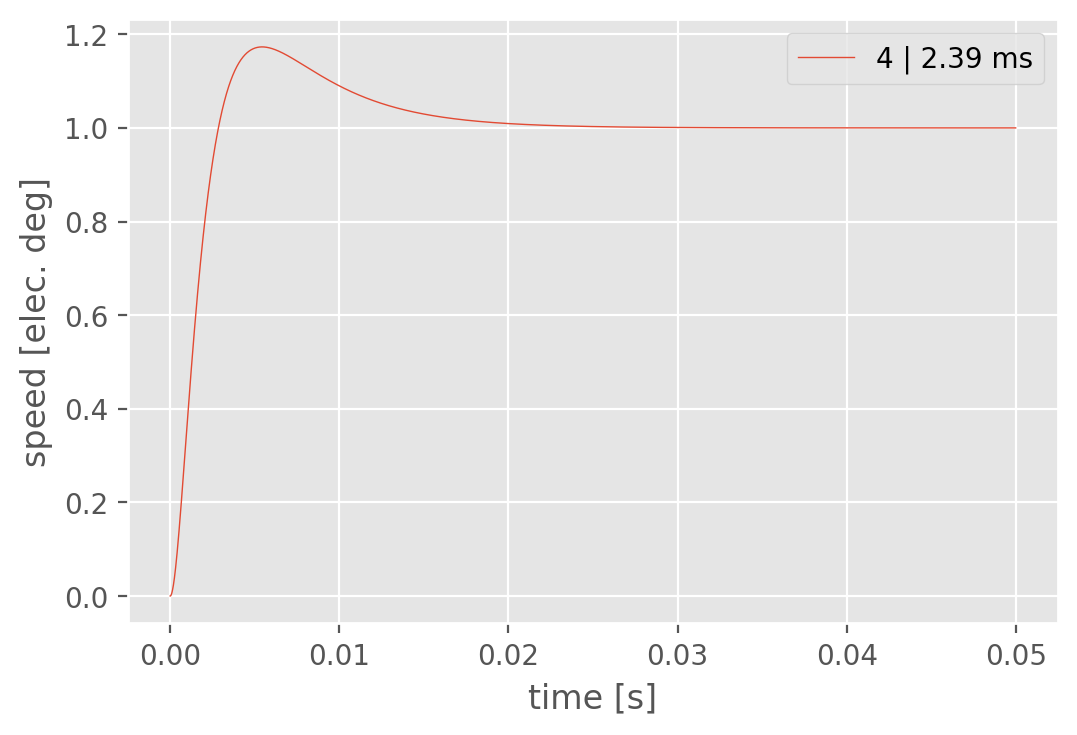

In [212]:
# Iterate for a preset speed rise time and delta

# Pick your favorite step repsonse by "shape" via damping factor \delta
delta = 4

# Specify your desired speed step response rise time
desired_rise_time_ms = 2.3

rise_time_ms = 10000 # ms (initial)
BW_current_Hz = 100 # Hz (initial)
while True:
    # Current loop (Tune its bandwidth to support required speed response)
    if abs(rise_time_ms - desired_rise_time_ms)<=0.1: # ms
        break
    else:
        if rise_time_ms > desired_rise_time_ms:
            BW_current_Hz += 10 # Hz
        else:
            BW_current_Hz -= 10 # Hz
            if BW_current_Hz<=0:
                raise Exception('Change the step size of "BW_current_Hz" and try again.')
                break
    print(f'BW_current_Hz = {BW_current_Hz}')
    R = 0.1 # Ohm
    L = 0.4 # H
    Kp, Ki = get_coeffs_dc_motor_current_regulator(R, L, BW_current_Hz)
    Gi_closed = control.tf([1], [L/Kp, 1])
    currentBandwidth_radPerSec = Kp/L

    # Speed loop
    n_pp = 2
    J_s  = 0.06
    dc_motor_motion = control.tf([n_pp/J_s], [1, 0])
    speedKp, speedKi = get_coeffs_dc_motor_SPEED_regulator(J_s, n_pp, delta, currentBandwidth_radPerSec)
    print(f'speedKp = {speedKp:g}', f'speedKi = {speedKi:g}', f'wzero = {speedKi/2/np.pi} Hz', f'cutoff = {delta*speedKi/2/np.pi} Hz', f'ipole = {Kp/L/2/np.pi} Hz', sep=' | ')

    speedPI = control.tf([speedKp, speedKp*speedKi], [1, 0])
    Gw_open = dc_motor_motion * Gi_closed * speedPI
    Gw_closed = Gw_open / (1+Gw_open)

    T, yout = control.step_response(Gw_closed, np.arange(0,0.05,1e-5))
    rise_time_ms = T[(np.abs(yout-0.9)).argmin()] * 1000 # <- Potential bug here! rise time is not always correct.

figure()
plt.plot(T, yout, lw='0.5', label=f'{delta:g} | {rise_time_ms:g} ms')
plt.xlabel('time [s]')
plt.ylabel('speed [elec. deg]')
plt.legend(loc='upper right')
